# Complete analysis for Experiment 3

In [95]:
rm(list= ls())

In [2]:
library(plyr)
library(dplyr)
library(tidyr)
library(ggplot2)
library(BayesFactor)
library(lme4)
library(lmerTest)
library(numform)


Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: coda
Loading required package: Matrix
Warning message:
"package 'Matrix' was built under R version 3.4.3"
Attaching package: 'Matrix'

The following object is masked from 'package:tidyr':

    expand

************
Welcome to BayesFactor 0.9.12-2. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************
Warning message:
"package 'lme4' was built under R version 3.4.3"Warning message:
"package 'lmerTest' was built under R version 3.4.3"
Attaching package: 'lmerTest'

The following object is masked from 'package:lme4':

    lmer

The following object is masked fro

## Loading the data

In [4]:
data.folder <- 'Experiment 3'
file.list <- list.files(path= data.folder, pattern= 'csv$')
reports <- data.frame()
for(current.filename in file.list){
    current.observer <- read.csv2(file.path(paste(data.folder, current.filename, sep='/')))
    current.observer$Yellow <- current.observer$Yellow=='True'
    reports <- rbind(reports, current.observer)
}

# Combining a single object trigger and a single switch reports into a single value

reports$Switch.comb <- as.character(reports$Switch)
reports$Switch.comb[reports$Switch.comb %in% c('left', 'right')] <- 'single'
reports$Switch.comb <- factor(reports$Switch.comb, levels = c('neither', 'single', 'both'))
reports$Switch.comb <- plyr::revalue(reports$Switch.comb, c("neither"="no trigger", "single"="single trigger", "both"="double trigger"))


reports$Response.comb <- as.character(reports$Response)
reports$Response.comb[reports$Response.comb %in% c('left', 'right')] <- 'single'
reports$Response.comb <- factor(reports$Response.comb, levels = c('neither', 'single', 'both'))
reports$Response.comb <- plyr::revalue(reports$Response.comb, c("neither"="no switch", "single"="single switch", "both"="double switch"))

reports <- reports %>%
    mutate(Gap.Label= recode(Gap, '-0.15'= 'overlap', '0'='touching', '0.15'= 'gap')) %>%
    mutate(Gap.Label= factor(Gap.Label, levels= c('overlap', 'touching', 'gap')))

# Excluding observers who failed to respond to the exogenous trigger
overall.trigger.efficiency <- reports %>%
    dplyr::filter(Switch!='neither') %>%
    dplyr::group_by(Observer) %>%
    dplyr::summarize(switch.fraction= mean(Response!='neither'))

overly.stable.observers <- overall.trigger.efficiency$Observer[overall.trigger.efficiency$switch.fraction<0.25]
spontaneous.switch.rate <- reports %>%
    dplyr::filter(Switch=='neither') %>%
    dplyr::group_by(Observer) %>%
    dplyr::summarize(switch.fraction= mean(Response!='neither'))
overly.instable.observers <- spontaneous.switch.rate$Observer[spontaneous.switch.rate$switch.fraction>0.5]

reports$Observer <- as.factor(as.character(reports$Observer))

# recomputing for methods after excluding overly stable observers
overall.trigger.efficiency <- reports %>%
    dplyr::filter(Switch!='neither') %>%
    dplyr::group_by(Observer) %>%
    dplyr::summarize(switch.fraction= mean(Response!='neither'))

overall.trigger.efficiency

summary(overall.trigger.efficiency$switch.fraction)

Observer,switch.fraction
ACR94m,0.08201058
ASA97w,0.73513514
AZM90w,0.63227513
BBW97w,0.22606383
ERK91m,0.78238342
MCB93w,0.72751323
NSM89w,0.74064171
RZN88w,0.89572193
SBS92w,0.52432432
SGP95w,0.37978142


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.08201 0.44753 0.67989 0.57795 0.73977 0.89572 

## Effect of the exogenous trigger (or of its absence) and of the layout

Computing proprtion of reports of all kinds (`neither`, `single`, and `both`; columns) vs. type of the exogenous trigger (`neither`, `single`, and `both`; rows)

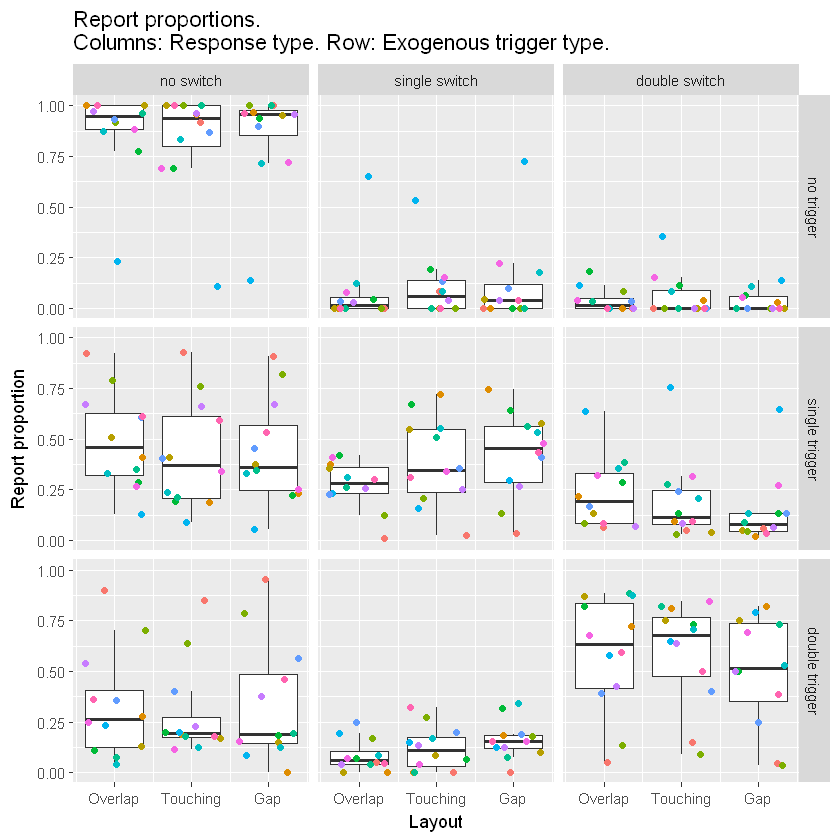

In [5]:
trigger.count <- reports %>%
    dplyr::group_by(Observer, Switch.comb, Gap, Response.comb) %>%
    dplyr::summarize(response.count= n()) %>%
    dplyr::ungroup() %>%
    tidyr::complete(Observer, Switch.comb, Gap, Response.comb) %>%
    dplyr::mutate(response.count= ifelse(is.na(response.count), 0, response.count)) %>%
    dplyr::group_by(Observer, Gap, Switch.comb) %>%
    dplyr::mutate(report.proportion= response.count/sum(response.count))

proportion.plot <- ggplot(data= trigger.count, aes(x= Gap, group= Gap, y= report.proportion, color= Observer))+
    geom_boxplot(outlier.shape = NA) +
    geom_jitter(aes(color= Observer)) +
    xlab('Layout') +
    ylab('Report proportion')+
    theme(legend.position='none') +
    facet_grid(Switch.comb ~ Response.comb)+
    ggtitle('Report proportions.\nColumns: Response type. Row: Exogenous trigger type.')+
    scale_x_continuous(breaks = c(sort(unique(trigger.count$Gap))), labels = c('Overlap', 'Touching', 'Gap'))
print(proportion.plot)
# ggsave('Exp2 - trigger vs report.pdf')

Same information but plotted in a somewhat easier to see way (__Figure 5__ in the manuscript)

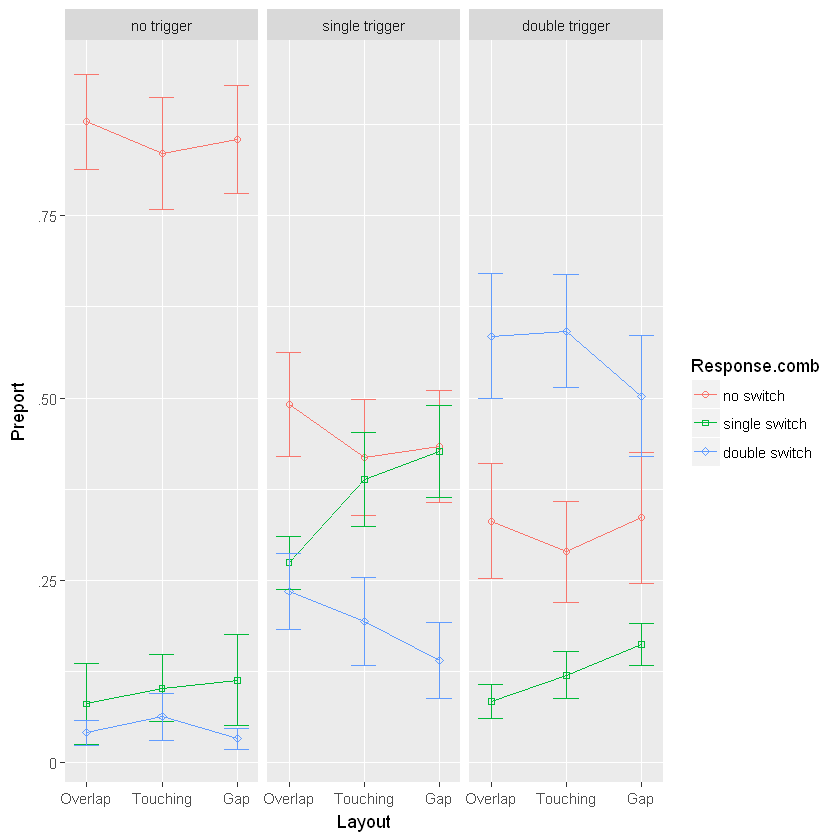

In [6]:
group.trigger.count <- reports %>%
    dplyr::group_by(Observer, Switch.comb, Gap, Response.comb) %>%
    dplyr::summarize(response.count= n()) %>%
    dplyr::ungroup() %>%
    tidyr::complete(Observer, Switch.comb, Gap, Response.comb) %>%
    dplyr::mutate(response.count= ifelse(is.na(response.count), 0, response.count)) %>%
    dplyr::group_by(Observer, Gap, Switch.comb) %>%
    dplyr::mutate(report.proportion= response.count/sum(response.count)) %>%
    dplyr::group_by(Switch.comb, Gap, Response.comb) %>%
    dplyr::summarize(P.report= mean(report.proportion), 
                     P.serr= sd(report.proportion)/sqrt(n()-1))

proportion.plot <- ggplot(data= group.trigger.count, aes(x= Gap, 
                                                         y= P.report, ymin= P.report-P.serr, ymax= P.report+P.serr,
                                                         color= Response.comb, shape= Response.comb))+
    geom_line() +
    geom_point() +
    geom_errorbar(width=0.05) + 
    xlab('Layout') +
    ylab('Preport')+
#     theme(legend.position='none') +
    facet_grid(. ~ Switch.comb)+
#     ggtitle('Report proportions.\nColumns: Response type. Row: Exogenous trigger type.')+
    scale_x_continuous(breaks = c(sort(unique(trigger.count$Gap))), labels = c('Overlap', 'Touching', 'Gap'))+
    scale_y_continuous(labels = numform::ff_num(zero = 0, digits= 2))+
    theme(panel.grid.minor.x=element_blank())+
    scale_shape_manual(values=c(21, 22, 23))


print(proportion.plot)
ggsave('Exp2 - proportion plot.pdf', proportion.plot, width= 16, height= 8, units = 'cm')
# ggsave('Exp2 - trigger vs report.pdf')

#### Statistical comparison for each trigger type (tables above plots in Figure 5)
Given the _no_ visible dependence of reports on the layout, testing whether gap has an effect on the overall probability of the switch
Using only __neither__ reports and __single__ and __both__ trigger types

In [7]:
rcontrast<-function(t, df) {
    return (sqrt(t^2/(t^2 + df)))
}

In [101]:
neither.reports <- trigger.count %>%
    dplyr::filter((Response.comb=='no switch') & (Switch.comb!='no trigger'))

lm.null <- lme4::lmer(report.proportion ~ 1 + (1|Observer), data= neither.reports, REML= FALSE)
lm.trigger <- update(lm.null, .~. + Switch.comb)
lm.layout <- update(lm.trigger, .~. + Gap)
lm.interaction <- update(lm.layout, .~. + Switch.comb * Gap)
neither.report.anova <-  anova(lm.null, lm.trigger, lm.layout, lm.interaction)
neither.report.anova
neither.report.anova$'Pr(>Chisq)'


lmer.report <- summary(lmerTest::lmer(report.proportion ~ Switch.comb + Gap + Switch.comb + (1|Observer), data= neither.reports))

coefficients.only <- data.frame(summary(lmer.report)$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,-61.12972,-54.29973,33.56486,-67.12972,NA,NA,NA
lm.trigger,4,-86.91478,-77.80812,47.45739,-94.91478,27.785058,1,1.355691e-07
lm.layout,5,-85.95102,-74.56769,47.97551,-95.95102,1.036234,1,3.086990e-01
lm.interaction,6,-85.36400,-71.70400,48.68200,-97.36400,1.412983,1,2.345617e-01


[1]           NA 1.355691e-07 3.086990e-01 2.345617e-01

Estimate,Std.Error,df,t.value,p.value,R.sqr
0.44780017,0.07159213,11.53368,6.254880,5.039704e-05,0.8788168
-0.12929924,0.02193240,58.00014,-5.895353,2.026535e-07,0.6121254
-0.09000271,0.08953864,58.00014,-1.005183,3.189841e-01,0.1308520


Given the _positive_ dependence of the `single` reports  on the layout, testing for its significance. Using only __single__ reports and __single__ and __both__ trigger types

In [8]:
single.reports <- trigger.count %>%
    dplyr::filter((Response.comb=='single switch') & (Switch.comb!='no trigger'))
lm.null <- lme4::lmer(report.proportion ~ 1 + (1|Observer), data= single.reports, REML= FALSE)
lm.trigger <- update(lm.null, .~. + Switch.comb)
lm.layout <- update(lm.trigger, .~. + Gap)
lm.interaction <- update(lm.layout, .~. + Switch.comb * Gap)
single.report.anova <- anova(lm.null, lm.trigger, lm.layout, lm.interaction)
single.report.anova
single.report.anova$'Pr(>Chisq)'

lmer.report <- summary(lmerTest::lmer(report.proportion ~ Switch.comb + Gap +  (1|Observer), data= single.reports))

lmer.report
coefficients.only <- data.frame(summary(lmer.report)$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,-27.21998,-20.38998,16.60999,-33.21998,NA,NA,NA
lm.trigger,4,-66.35329,-57.24662,37.17664,-74.35329,41.133305,1,1.421926e-10
lm.layout,5,-74.14095,-62.75762,42.07048,-84.14095,9.787668,1,1.756861e-03
lm.interaction,6,-73.26318,-59.60318,42.63159,-85.26318,1.122226,1,2.894396e-01


[1]           NA 1.421926e-10 1.756861e-03 2.894396e-01

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: report.proportion ~ Switch.comb + Gap + (1 | Observer)
   Data: single.reports

REML criterion at convergence: -71

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9576 -0.6531 -0.1518  0.4809  2.3250 

Random effects:
 Groups   Name        Variance Std.Dev.
 Observer (Intercept) 0.006018 0.07757 
 Residual             0.015547 0.12469 
Number of obs: 72, groups:  Observer, 12

Fixed effects:
                          Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)                0.36288    0.03055 18.30000  11.878 4.86e-10 ***
Switch.combdouble trigger -0.24100    0.02939 58.00000  -8.200 2.83e-11 ***
Gap                        0.38463    0.11998 58.00000   3.206  0.00219 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr) Swtc.t
Swtch.cmbdt -0.481       
Gap          0.000  

Estimate,Std.Error,df,t.value,p.value,R.sqr
0.3628799,0.03055094,18.30378,11.877864,4.858571e-10,0.9408303
-0.2410013,0.02938952,58.00007,-8.200247,2.830203e-11,0.7327372
0.3846334,0.11998222,58.00007,3.205753,2.192086e-03,0.3879655


The analysis shows that the smaller gap produces fewer __single__ switch responses (highly significant _positive_ slope for `Gap`) and that there were fewer __single__ switch responses for when the exogenous trigger was applied to __both__ spheres (highly significant negative factor for `Switch.combboth`). However, there is no evidence for the interaction.

Given the _negative_ dependence of the `both` reports  on the layout, testing for its significance. Using only __both__ reports and __single__ and __both__ trigger types

In [103]:
both.reports <- trigger.count %>%
    dplyr::filter((Response.comb=='double switch') & (Switch.comb!='no trigger'))

lm.null <- lme4::lmer(report.proportion ~ 1 + (1|Observer), data= both.reports, REML= FALSE)
lm.trigger <- update(lm.null, .~. + Switch.comb)
lm.layout <- update(lm.trigger, .~. + Gap)
lm.interaction <- update(lm.layout, .~. + Switch.comb * Gap)
both.report.anova <- anova(lm.null, lm.trigger, lm.layout, lm.interaction)
both.report.anova
both.report.anova$Chisq
both.report.anova$'Pr(>Chisq)'

lmer.report <- summary(lmerTest::lmer(report.proportion ~ Switch.comb + Gap  + (1|Observer), data= both.reports))

lmer.report
coefficients.only <- data.frame(summary(lmer.report)$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,26.27093,33.10093,-10.13547,20.27093,NA,NA,NA
lm.trigger,4,-31.59586,-22.48920,19.79793,-39.59586,59.86679380,1,1.014996e-14
lm.layout,5,-33.63082,-22.24749,21.81541,-43.63082,4.03495700,1,4.456681e-02
lm.interaction,6,-31.65074,-17.99074,21.82537,-43.65074,0.01992091,1,8.877582e-01


[1]          NA 59.86679380  4.03495700  0.01992091

[1]           NA 1.014996e-14 4.456681e-02 8.877582e-01

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: report.proportion ~ Switch.comb + Gap + (1 | Observer)
   Data: both.reports

REML criterion at convergence: -32.7

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.93140 -0.64564 -0.01935  0.79617  1.95528 

Random effects:
 Groups   Name        Variance Std.Dev.
 Observer (Intercept) 0.02989  0.1729  
 Residual             0.02324  0.1524  
Number of obs: 72, groups:  Observer, 12

Fixed effects:
                          Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)                0.18932    0.05600 13.63000   3.380  0.00463 ** 
Switch.combdouble trigger  0.37030    0.03593 58.00000  10.306 9.99e-15 ***
Gap                       -0.29463    0.14668 58.00000  -2.009  0.04924 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr) Swtc.t
Swtch.cmbdt -0.321       
Gap       

Estimate,Std.Error,df,t.value,p.value,R.sqr
0.1893200,0.05600391,13.63413,3.380478,4.634757e-03,0.6752619
0.3703006,0.03592968,58.00005,10.306259,9.992007e-15,0.8042468
-0.2946307,0.14668231,58.00005,-2.008631,4.923953e-02,0.2550252


The analysis shows that the smaller gap produces more __both__ switch responses (significant _negative_ slope for `Gap`) and that there were fewer __both__ switch responses for when the exogenous trigger was applied to a __single__ sphere only (highly significant positive factor for `Switch.combboth`). However, there is no evidence for the interaction.

Analysis shows that there were more reported switch when the exogenous trigger was applied to __both__ spheres (highly significant _negative_ effect for the `Switch.combboth` means that there were fewer 'no switch' responses, hence, more 'switch responses'). However, there was neither an effect of the `Gap`, nor of `Switch` x `Gap` interaction.

# Effect of the history

__Figure 6__ in the manuscript





Adding information about the prior trial

In [120]:
single.responses <- c('left', 'right')

prior.response.given.current <- function(current.response, prior.response){
    transformed.response <- prior.response
    transformed.response[(prior.response %in%  c('left', 'right'))] <- 'single switch';
    
    return(transformed.response);
}

reports <- reports %>%
    group_by(Observer, Block) %>%

    # figure out the response
    mutate(prior.response= lag(Response)) %>%
    mutate(prior.response= prior.response.given.current(as.character(Response), as.character(prior.response))) %>%
    mutate(prior.response= factor(prior.response, levels= c('neither', 'single switch', 'both')))

Plotting proportions of __"no switch"__ responses given the prior trial outcome

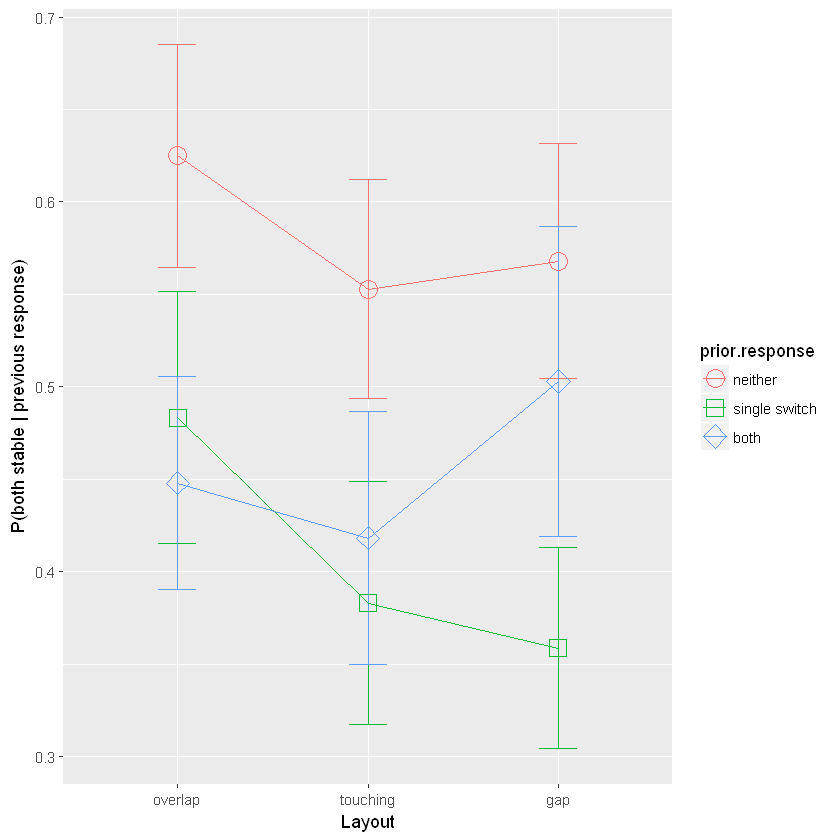

In [149]:
no.switch.history <- reports %>%
    filter(!is.na(prior.response)) %>%
    group_by(Observer, Gap.Label, prior.response) %>%
    summarize(P.no.switch= sum(Response.comb=='no switch')/n())

no.switch.summary <- no.switch.history %>%
    group_by(Gap.Label, prior.response) %>%
    summarise(P.mean= mean(P.no.switch),
              P.serr= sd(P.no.switch)/sqrt(n()-1))

no.switch.history.plot <- ggplot(data= no.switch.summary, 
                                 aes(x= Gap.Label, y= P.mean, ymin= P.mean-P.serr, ymax= P.mean+P.serr,
                                     color= prior.response, group= prior.response, shape= prior.response)) + 
    geom_errorbar(width= 0.2)+
    geom_line()+
    geom_point(size= 5)+
    theme(legend.position='none', panel.grid.major.x = element_blank())+
    scale_shape_manual(values=c(21, 22, 23))+
    xlab('Layout')+
    ylab('P(both stable | previous response)')
print(no.switch.history.plot)
ggsave('Figures/Exp3 - Pstable x layout.pdf', no.switch.history.plot, width= 6.5, height= 6.5, units = 'cm',  useDingbats = FALSE)

In [137]:
# overlap
overlap <- data.frame(summary(lmerTest::lmer(P.no.switch ~ prior.response + (1|Observer), 
                       data= no.switch.history %>% filter(Gap.Label=='overlap')))$coefficients)[2:3, ]
overlap$layout <- 'overlap'
overlap$prior.response <- c('single switch', 'double switch')


touching <- data.frame(summary(lmerTest::lmer(P.no.switch ~ prior.response + (1|Observer), 
                       data= no.switch.history %>% filter(Gap.Label=='touching')))$coefficients)[2:3, ]
touching$layout <- 'touching'
touching$prior.response <- c('single switch', 'double switch')

gap <- data.frame(summary(lmerTest::lmer(P.no.switch ~ prior.response + (1|Observer), 
                       data= no.switch.history %>% filter(Gap.Label=='gap')))$coefficients)[2:3, ]
gap$layout <- 'gap'
gap$prior.response <- c('single switch', 'double switch')

no.switch.priming <- rbind(overlap, touching, gap)
colnames(no.switch.priming) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value', 'layout', 'prior.response')
rownames(no.switch.priming) <- NULL
no.switch.priming <- no.switch.priming %>%
    mutate(R.sqr= rcontrast(t.value, df), 
           p.adjusted= p.adjust(p.value, method = 'holm'))
no.switch.priming

Estimate,Std.Error,df,t.value,p.value,layout,prior.response,R.sqr,p.adjusted
-0.1416830,0.05429701,22.00002,-2.609408,0.0160082099,overlap,single switch,0.4861583,0.032016420
-0.1769087,0.05429701,22.00002,-3.258167,0.0036018912,overlap,double switch,0.5705060,0.014407565
-0.1698291,0.04235789,22.00003,-4.009385,0.0005895017,touching,single switch,0.6497655,0.003537010
-0.1345107,0.04235789,22.00003,-3.175576,0.0043765773,touching,double switch,0.5606298,0.014407565
-0.2093192,0.05594148,22.00002,-3.741753,0.0011299014,gap,single switch,0.6236191,0.005649507
-0.0650861,0.05594148,22.00002,-1.163468,0.2571039311,gap,double switch,0.2407558,0.257103931


Plotting proportions of __"single switch"__ responses given the prior trial outcome

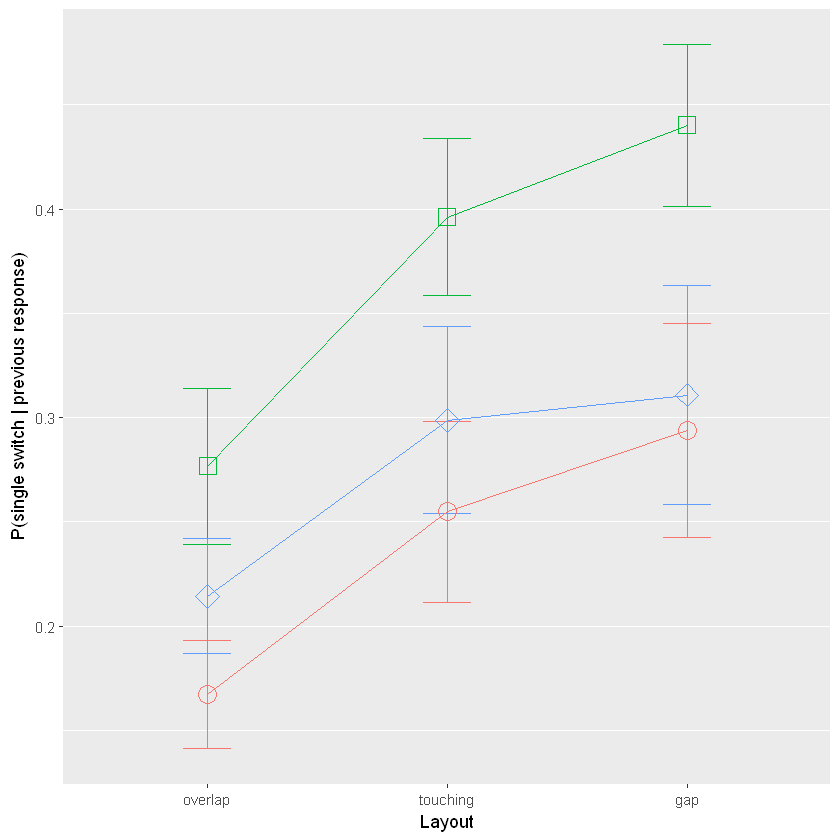

In [161]:
single.switch.history <- reports %>%
    filter(!is.na(prior.response)) %>%
    group_by(Observer, Gap.Label, prior.response) %>%
    summarize(P.single.switch= sum(Response.comb=='single switch')/n())

single.switch.summary <- single.switch.history %>%
    group_by(Gap.Label, prior.response) %>%
    summarise(P.mean= mean(P.single.switch),
              P.serr= sd(P.single.switch)/sqrt(n()-1))

single.switch.history.plot <- ggplot(data= single.switch.summary, 
                                 aes(x= Gap.Label, y= P.mean, ymin= P.mean-P.serr, ymax= P.mean+P.serr,
                                     color= prior.response, group= prior.response, shape= prior.response)) + 
    geom_errorbar(width= 0.2)+
    geom_line()+
    geom_point(size= 5)+
    theme(legend.position='none', panel.grid.major.x = element_blank())+
    scale_shape_manual(values=c(21, 22, 23))+
    xlab('Layout')+
    ylab('P(single switch | previous response)')
print(single.switch.history.plot)
ggsave('Figures/Exp3 - Psingle x layout.pdf', single.switch.history.plot, width= 6.5, height= 6.5, units = 'cm',  useDingbats = FALSE)

In [158]:
# overlap
single.switch.history <- single.switch.history %>% 
    mutate(prior.response= factor(prior.response, levels= c('single switch', 'neither', 'both')))

overlap <- data.frame(summary(lmerTest::lmer(P.single.switch ~ prior.response + (1|Observer), 
                       data= single.switch.history %>% filter(Gap.Label=='overlap')))$coefficients)[2:3, ]
overlap$layout <- 'overlap'
overlap$prior.response <- c('both stable', 'double switch')


touching <- data.frame(summary(lmerTest::lmer(P.single.switch ~ prior.response + (1|Observer), 
                       data= single.switch.history %>% filter(Gap.Label=='touching')))$coefficients)[2:3, ]
touching$layout <- 'touching'
touching$prior.response <- c('both stable', 'double switch')

gap <- data.frame(summary(lmerTest::lmer(P.single.switch ~ prior.response + (1|Observer), 
                       data= single.switch.history %>% filter(Gap.Label=='gap')))$coefficients)[2:3, ]
gap$layout <- 'gap'
gap$prior.response <- c('both stable', 'double switch')

single.switch.priming <- rbind(overlap, touching, gap)
colnames(single.switch.priming) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value', 'layout', 'prior.response')
rownames(single.switch.priming) <- NULL
single.switch.priming <- single.switch.priming %>%
    mutate(R.sqr= rcontrast(t.value, df), 
           p.adjusted= p.adjust(p.value, method = 'holm'))
single.switch.priming

Estimate,Std.Error,df,t.value,p.value,layout,prior.response,R.sqr,p.adjusted
-0.10959562,0.03191251,22.00005,-3.434253,0.002369295,overlap,both stable,0.5907606,0.011846476
-0.06233060,0.03191251,22.00005,-1.953172,0.063634627,overlap,double switch,0.3844191,0.063634627
-0.14126804,0.03877752,22.00003,-3.643039,0.001434552,touching,both stable,0.6134091,0.008607311
-0.09740349,0.03877752,22.00003,-2.511854,0.019846176,touching,double switch,0.4720943,0.059538528
-0.14639119,0.05304849,22.00002,-2.759573,0.011436455,gap,both stable,0.5070889,0.045745818
-0.12938243,0.05304849,22.00002,-2.438947,0.023257830,gap,double switch,0.4613422,0.059538528


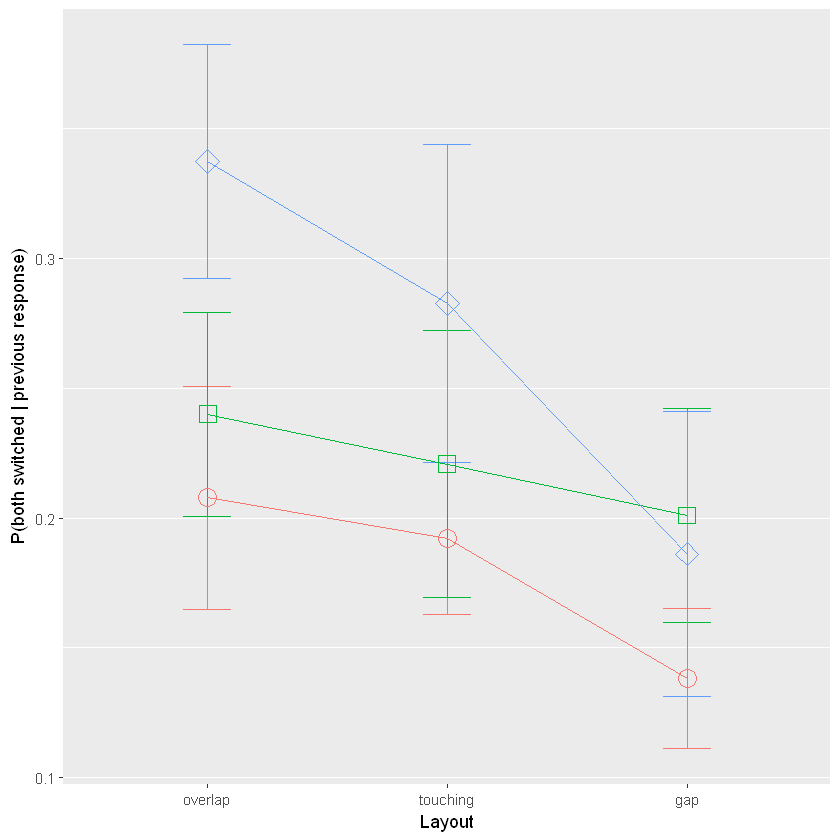

In [165]:
double.switch.history <- reports %>%
    filter(!is.na(prior.response)) %>%
    group_by(Observer, Gap.Label, prior.response) %>%
    summarize(P.double.switch= sum(Response.comb=='double switch')/n())

double.switch.summary <- double.switch.history %>%
    group_by(Gap.Label, prior.response) %>%
    summarise(P.mean= mean(P.double.switch),
              P.serr= sd(P.double.switch)/sqrt(n()-1))

double.switch.history.plot <- ggplot(data= double.switch.summary, 
                                 aes(x= Gap.Label, y= P.mean, ymin= P.mean-P.serr, ymax= P.mean+P.serr,
                                     color= prior.response, group= prior.response, shape= prior.response)) + 
    geom_errorbar(width= 0.2)+
    geom_line()+
    geom_point(size= 5)+
    theme(legend.position='none', panel.grid.major.x = element_blank())+
    scale_shape_manual(values=c(21, 22, 23))+    xlab('Layout')+
    ylab('P(both switched | previous response)')
print(double.switch.history.plot)
ggsave('Figures/Exp3 - Pdual x layout.pdf', double.switch.history.plot, width= 6.5, height= 6.5, units = 'cm',  useDingbats = FALSE)

In [166]:
# overlap
double.switch.history <- double.switch.history %>% 
    mutate(prior.response= factor(prior.response, levels= c('both', 'neither', 'single switch')))

overlap <- data.frame(summary(lmerTest::lmer(P.double.switch ~ prior.response + (1|Observer), 
                       data= double.switch.history %>% filter(Gap.Label=='overlap')))$coefficients)[2:3, ]
overlap$layout <- 'overlap'
overlap$prior.response <- c('both stable', 'single switch')


touching <- data.frame(summary(lmerTest::lmer(P.double.switch ~ prior.response + (1|Observer), 
                       data= double.switch.history %>% filter(Gap.Label=='touching')))$coefficients)[2:3, ]
touching$layout <- 'touching'
touching$prior.response <- c('both stable', 'single switch')

gap <- data.frame(summary(lmerTest::lmer(P.double.switch ~ prior.response + (1|Observer), 
                       data= double.switch.history %>% filter(Gap.Label=='gap')))$coefficients)[2:3, ]
gap$layout <- 'gap'
gap$prior.response <- c('both stable', 'single switch')

double.switch.priming <- rbind(overlap, touching, gap)
colnames(double.switch.priming) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value', 'layout', 'prior.response')
rownames(double.switch.priming) <- NULL
double.switch.priming <- double.switch.priming %>%
    mutate(R.sqr= rcontrast(t.value, df), 
           p.adjusted= p.adjust(p.value, method = 'holm'))
double.switch.priming

Estimate,Std.Error,df,t.value,p.value,layout,prior.response,R.sqr,p.adjusted
-0.12964372,0.04143841,22.00003,-3.1285884,0.004886944,overlap,both stable,0.55490187,0.02932166
-0.09755630,0.04143841,22.00003,-2.3542482,0.027900890,overlap,single switch,0.44859091,0.13950445
-0.09064618,0.04057048,22.00003,-2.2342891,0.035945801,touching,both stable,0.43005223,0.14378320
-0.06208514,0.04057048,22.00003,-1.5303032,0.140194908,touching,single switch,0.31017060,0.42058472
-0.04807733,0.03391964,22.00004,-1.4173895,0.170376802,gap,both stable,0.28926896,0.42058472
0.01485064,0.03391964,22.00004,0.4378185,0.665786239,gap,single switch,0.09293912,0.66578624


Single switch preceded by a single switch only

In [190]:
reports <- reports %>%
    group_by(Observer, Block) %>%

    # figure out the response
    mutate(prior.response= lag(Response))

right.switch.history <- reports %>%
    filter(!is.na(prior.response)) %>%
    group_by(Observer, prior.response) %>%
    summarize(P.single.switch= sum(Response=='right')/n()) %>%
    mutate(prior.response= factor(prior.response, levels=  c('neither', 'left', 'right', 'both')))

reports <- reports %>%
    group_by(Observer, Block) %>%

    # figure out the response
    mutate(prior.response= lag(Response))

left.switch.history <- reports %>%
    filter(!is.na(prior.response)) %>%
    group_by(Observer, Gap.Label, prior.response) %>%
    summarize(P.single.switch= sum(Response=='left')/n()) %>%
    filter(prior.response %in% c('left', 'right')) %>%
    mutate(same.side= prior.response == 'left')

right.switch.history <- reports %>%
    filter(!is.na(prior.response)) %>%
    group_by(Observer, Gap.Label, prior.response) %>%
    summarize(P.single.switch= sum(Response=='right')/n()) %>%
    filter(prior.response %in% c('left', 'right')) %>%
    mutate(same.side= prior.response == 'right')

single.switch.history <-  left.switch.history %>%
    rbind(right.switch.history) %>%
    group_by(Observer, Gap.Label, same.side) %>%
    summarize(P.single.switch= mean(P.single.switch))

Accompanying statistics

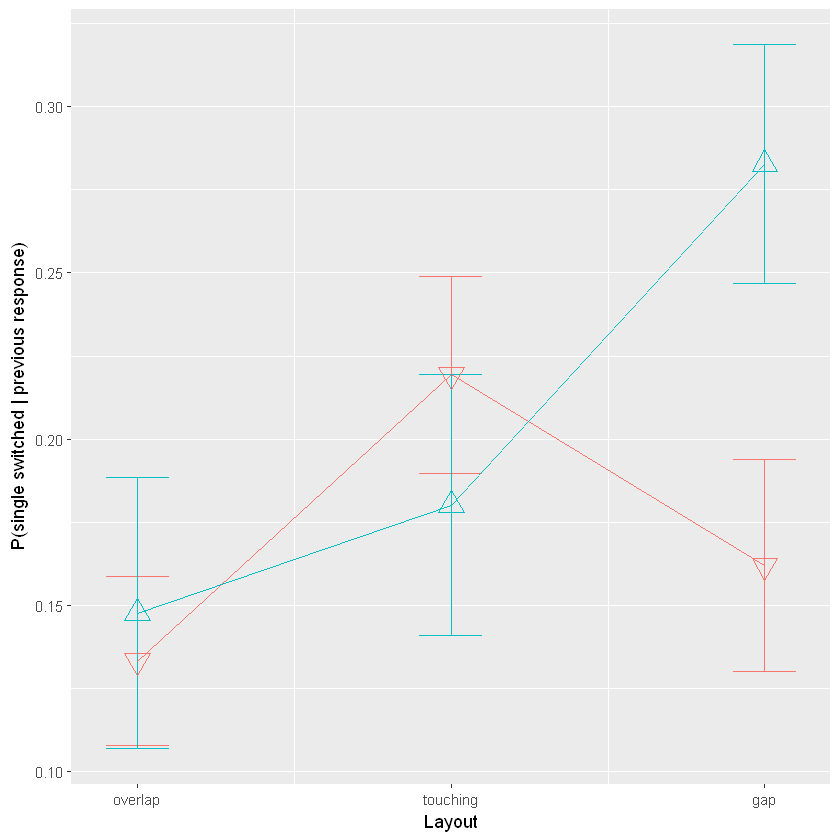

In [200]:
side.summary <- single.switch.history %>%
    group_by(Gap.Label, same.side) %>%
    summarise(P.mean= mean(P.single.switch),
              P.serr= sd(P.single.switch)/sqrt(n()-1))

single.switch.history.plot <- ggplot(data= side.summary, 
                                     aes(x= as.numeric(Gap.Label), 
                                         y= P.mean, ymin= P.mean-P.serr, ymax= P.mean+P.serr,
                                         color= same.side, shape= same.side)) + 
    geom_errorbar(width= 0.2)+
    geom_line()+
    geom_point(size= 5)+
    scale_x_continuous(breaks= c(1:3), labels = c('overlap', 'touching', 'gap'))+
    theme(legend.position='none', panel.grid.major.x = element_blank())+
    xlab('Layout')+
    scale_shape_manual(values=c(25, 24))+    
    xlab('Layout')+
    ylab('P(single switched | previous response)')
print(single.switch.history.plot)
ggsave('Figures/Exp3 - Psingle side x layout.pdf', single.switch.history.plot, width= 6.5, height= 6.5, units = 'cm',  useDingbats = FALSE)

In [201]:
# overlap
single.switch.history <- single.switch.history %>%
    mutate(same.side= factor(same.side, levels= c('TRUE', 'FALSE')))

overlap <- data.frame(summary(lmerTest::lmer(P.single.switch ~ same.side + (1|Observer), 
                       data= single.switch.history %>% filter(Gap.Label=='overlap')))$coefficients)[2, ]
overlap$layout <- 'overlap'

touching <- data.frame(summary(lmerTest::lmer(P.single.switch ~ same.side + (1|Observer), 
                       data= single.switch.history %>% filter(Gap.Label=='touching')))$coefficients)[2, ]
touching$layout <- 'touching'

gap <- data.frame(summary(lmerTest::lmer(P.single.switch ~ same.side + (1|Observer), 
                       data= single.switch.history %>% filter(Gap.Label=='gap')))$coefficients)[2, ]
gap$layout <- 'gap'

single.switch.priming <- rbind(overlap, touching, gap)
colnames(single.switch.priming) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value', 'layout')
rownames(single.switch.priming) <- NULL
single.switch.priming <- single.switch.priming %>%
    mutate(R.sqr= rcontrast(t.value, df), 
           p.adjusted= p.adjust(p.value, method = 'holm'))
single.switch.priming

Estimate,Std.Error,df,t.value,p.value,layout,R.sqr,p.adjusted
-0.01440164,0.04598105,22.00004,-0.3132081,0.75707259,overlap,0.06662776,0.82916516
0.03916237,0.04709406,22.00004,0.8315776,0.41458258,touching,0.17457041,0.82916516
-0.12069561,0.04597307,22.00004,-2.6253546,0.01545132,gap,0.48842199,0.04635397


## Looking at the effect of the trigger timing

SwitchTime,P.switch,P.serr
1.1,0.4030099,0.07646162
1.3,0.4042547,0.07270071
1.5,0.4258502,0.07723313
1.7,0.4153497,0.07664548
1.9,0.4642275,0.07165866


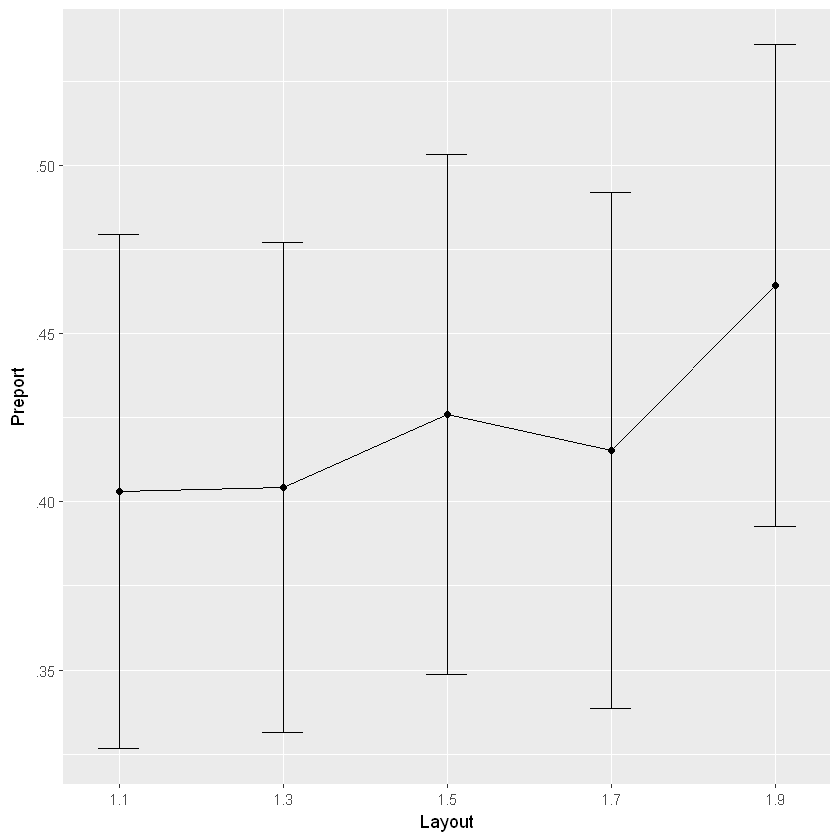

In [116]:
trigger.timing.effect <- reports %>%
    dplyr::filter(Switch.comb != 'no trigger') %>%
    dplyr::group_by(Observer, SwitchTime) %>%
    dplyr::summarize(switch.proportion= mean(Response.comb=='no switch')) %>%
    dplyr::group_by(SwitchTime) %>%
    dplyr::summarize(P.switch= mean(switch.proportion), 
                     P.serr= sd(switch.proportion)/sqrt(n()-1))
trigger.timing.effect

proportion.plot <- ggplot(data= trigger.timing.effect, aes(x= SwitchTime, 
                                                         y= P.switch, ymin= P.switch-P.serr, ymax= P.switch+P.serr))+
    geom_line() +
    geom_errorbar(width=0.05) + 
    geom_point() +
    xlab('Layout') +
    ylab('Preport')+
    scale_x_continuous(breaks = c(sort(unique(trigger.timing.effect$SwitchTime))))+
    scale_y_continuous(labels = numform::ff_num(zero = 0, digits= 2))+
    theme(panel.grid.minor.x=element_blank())

print(proportion.plot)
# ggsave('Exp2 - proportion plot.pdf', proportion.plot, width= 16, height= 8, units = 'cm')
# ggsave('Exp2 - trigger vs report.pdf')